<a href="https://colab.research.google.com/github/abhipavuluri/UHGeneSequencing_DrMohan/blob/main/Lpr_CsA_UA_analysis_volcanoplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential Expression Analysis Notebook

In [ ]:
!pip install openpyxl xlsxwriter --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 4.1 MB/s eta 0:00:00


In [ ]:
## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import xlsxwriter


In [ ]:
## Load Dataset

In [ ]:
df = pd.read_csv('/content/RNA_Seq_Differential_Gene_Transctpt_Exp_05092025.csv')

In [ ]:
## Define Group Columns

In [ ]:
group_cols = {
    'lpr': ['MRL1', 'MRL2', 'MRL3'],
    'CsA': ['CsA1', 'CsA2', 'CsA3'],
    'UA': ['UA1', 'UA2', 'UA3'],
    'CsA+UA': ['CsA+UA1', 'CsA+UA2', 'CsA+UA3']
}

In [ ]:
## Clean and Prepare Data

In [ ]:
df_clean = df.dropna(subset=['gene_name']).copy()
for group in group_cols.values():
    df_clean[group] = df_clean[group].astype(float)

In [ ]:
## Define Function to Compute Differential Expression

In [ ]:
def compute_de_fixed(df, group1_cols, group2_cols):
# Convert all expression values to numbers
    group1_expr = df[group1_cols].astype(float)
# Convert all expression values to numbers
    group2_expr = df[group2_cols].astype(float)
# Calculate the average expression of each gene in group 1
    mean1 = group1_expr.mean(axis=1)
# Calculate the average expression of each gene in group 2
    mean2 = group2_expr.mean(axis=1)
# Fold change: ratio of group1 expression to group2
    fc = (mean1 + 1e-6) / (mean2 + 1e-6)
# Fold change: ratio of group1 expression to group2
    log2fc = np.log2(fc)
# Perform a t-test to compare gene expression between two groups
    p_values = ttest_ind(group1_expr.values, group2_expr.values, axis=1, equal_var=False).pvalue
# Return a new table with gene name, fold change, log2FC, and p-value
    return pd.DataFrame({
        'gene_name': df['gene_name'].values,
        'FoldChange': fc,
        'Log2FC': log2fc,
        'p_value': p_values
    })

In [ ]:
## Compute DE Results

In [ ]:
# Define which columns (samples) belong to which treatment group
de_results = {
    'lpr_vs_CsA': compute_de_fixed(df_clean, group_cols['lpr'], group_cols['CsA']),
    'lpr_vs_UA': compute_de_fixed(df_clean, group_cols['lpr'], group_cols['UA']),
    'lpr_vs_CsA_UA': compute_de_fixed(df_clean, group_cols['lpr'], group_cols['CsA+UA'])
}

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [ ]:
## Apply Filtering: p < 0.05 and FC > 2 or FC < 0.5

In [ ]:
# Run the comparison function for each pair of groups
# Filter results to keep only strongly changed and significant genes
filtered_results = {
    name + '_filtered': df_[(df_['p_value'] < 0.05) & ((df_['FoldChange'] > 2) | (df_['FoldChange'] < 0.5))]
    for name, df_ in de_results.items()
}

In [ ]:
## Find Genes Unique to lpr vs CsA+UA

In [ ]:
# Keep only genes with strong changes (fold change > 2 or < 0.5) and statistically significant (p < 0.05)
unique_genes = set(filtered_results['lpr_vs_CsA_UA_filtered']['gene_name']) - \
               set(filtered_results['lpr_vs_CsA_filtered']['gene_name']) - \
               set(filtered_results['lpr_vs_UA_filtered']['gene_name'])

exclusive_genes = filtered_results['lpr_vs_CsA_UA_filtered'][
    filtered_results['lpr_vs_CsA_UA_filtered']['gene_name'].isin(unique_genes)
]

In [ ]:
## Export to Excel

In [ ]:
# Run the comparison function for each pair of groups
output_path = 'DE_Analysis_Corrected.xlsx'
with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    for name, df_ in de_results.items():
        df_.to_excel(writer, sheet_name=name, index=False)
    for name, df_ in filtered_results.items():
        df_.to_excel(writer, sheet_name=name, index=False)
    exclusive_genes.to_excel(writer, sheet_name='Unique_in_CsA_UA', index=False)

## Install and Import matplotlib

In [ ]:
# Install required libraries (only needed the first time you run the notebook)
!pip install matplotlib --quiet

In [ ]:
# Import matplotlib for plotting graphs and charts
import matplotlib.pyplot as plt
import os

## Function to Generate Volcano Plot

In [ ]:
# This function creates a volcano plot:
# X-axis: how much gene expression changes (log2 fold change)
# Y-axis: how statistically significant the change is (-log10 p-value)
# Red = increased, Blue = decreased, Gray = not significant
# Function to draw a volcano plot for each group comparison
def generate_volcano_plot(df, sheet_name):
    df = df[np.isfinite(df['FoldChange']) & (df['FoldChange'] > 0)].copy()

    # Simulate discrete p-values to produce striped look
    df['P value'] = df['p_value'].round(2)
    df['Log2FC'] = np.log2(df['FoldChange'])
    df['-log10 P-value'] = -np.log10(df['P value'])

    # Thresholds
    p_value_threshold = -np.log10(0.05)
    log2fc_threshold = 1

    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.scatter(df['Log2FC'], df['-log10 P-value'], color='gray', alpha=0.6, s=12, label='Insignificant')

    up = df[(df['Log2FC'] > log2fc_threshold) & (df['-log10 P-value'] > p_value_threshold)]
    down = df[(df['Log2FC'] < -log2fc_threshold) & (df['-log10 P-value'] > p_value_threshold)]

    ax.scatter(up['Log2FC'], up['-log10 P-value'], color='red', s=20, label='Up Regulated')
    ax.scatter(down['Log2FC'], down['-log10w P-value'], color='blue', s=20, label='Down Regulated')

    ax.axhline(y=p_value_threshold, color='darkred', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axvline(x=log2fc_threshold, color='darkred', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axvline(x=-log2fc_threshold, color='darkred', linestyle='-', linewidth=1.5, alpha=0.7)

    ax.set_xlabel("log2 Fold Change", fontsize=14, fontweight='bold')
    ax.set_ylabel("-log10 P-Value", fontsize=14, fontweight='bold')
    ax.set_title(f"Volcano Plot - {sheet_name.replace('_', ' ').replace(' filtered', ' ')}", fontsize=16, fontweight='bold')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), frameon=True, fontsize=12)

    os.makedirs("volcano_plots", exist_ok=True)
# Save the plot image to a file
    plt.savefig(f"volcano_plots/Volcano_Plot_{sheet_name}.png", bbox_inches='tight', dpi=300)
# Also show the plot in the notebook
    plt.show()
    plt.close()

    print(f"{sheet_name}: {len(df)} genes plotted after rounding P values.")

## Generate Volcano Plots for Filtered Comparisons

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


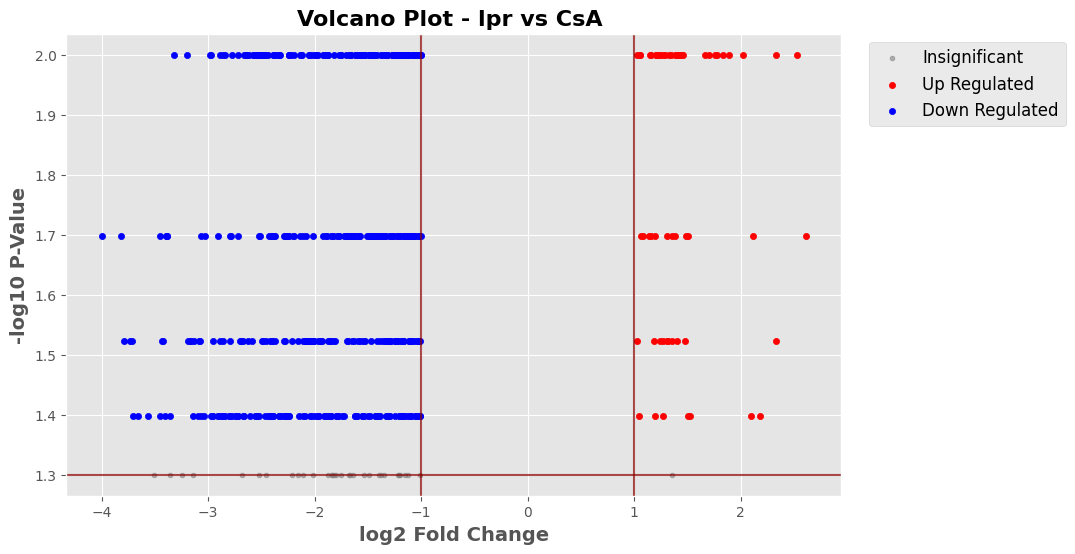

lpr_vs_CsA_filtered: 618 genes plotted after rounding P values.


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


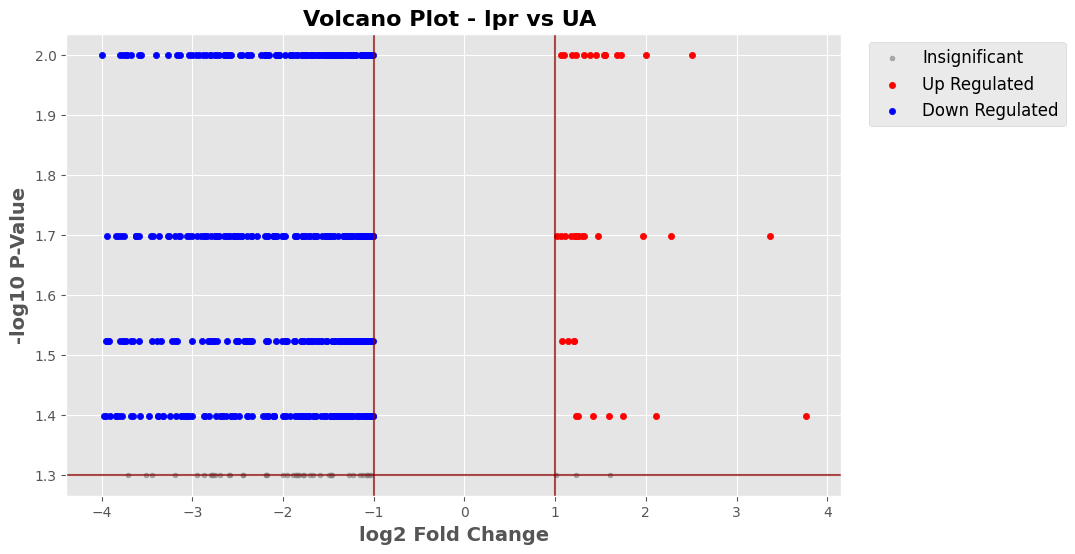

lpr_vs_UA_filtered: 656 genes plotted after rounding P values.


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


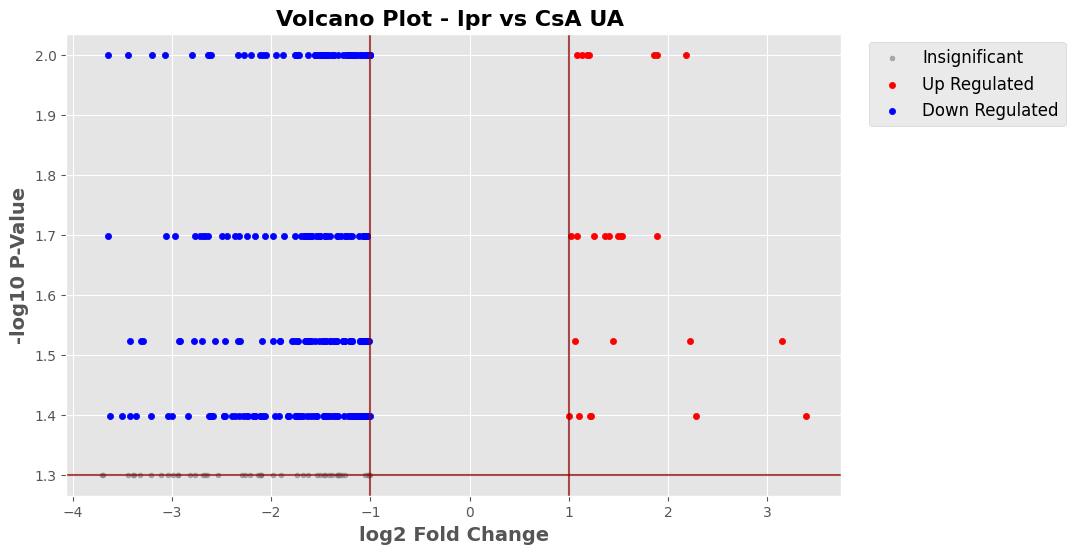

lpr_vs_CsA_UA_filtered: 390 genes plotted after rounding P values.


In [ ]:
# Keep only genes with strong changes (fold change > 2 or < 0.5) and statistically significant (p < 0.05)
for name, df_ in filtered_results.items():
# Function to draw a volcano plot for each group comparison
    generate_volcano_plot(df_, name)

## Install matplotlib-venn

In [ ]:
# Install required libraries (only needed the first time you run the notebook)
!pip install matplotlib-venn --quiet

## Import venn3 for Venn Diagram

In [ ]:
# Draw a Venn diagram to show how many genes are shared between comparisons
# Red circle = lpr vs CsA, Blue = lpr vs UA, Gray = lpr vs CsA+UA
# Import venn3 to draw Venn diagrams
from matplotlib_venn import venn3
# Import matplotlib for plotting graphs and charts
import matplotlib.pyplot as plt
import os

## Create Venn Diagram from Filtered Results

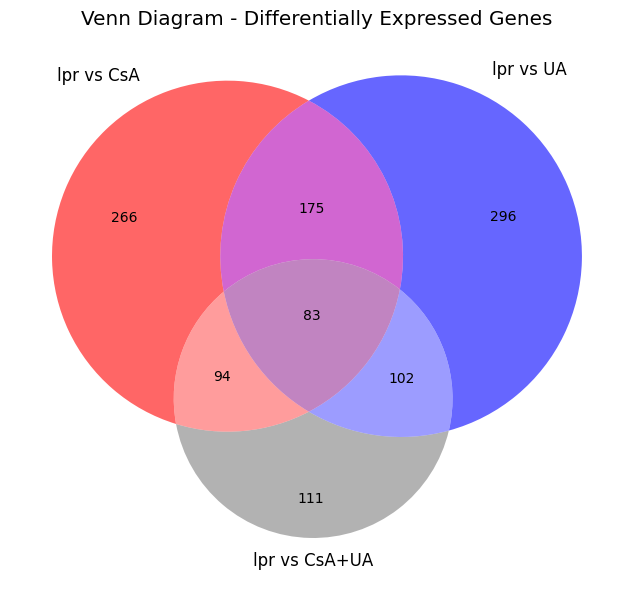

In [ ]:
# Keep only genes with strong changes (fold change > 2 or < 0.5) and statistically significant (p < 0.05)
# Prepare gene sets from filtered results
de_sets = {
    'lpr_vs_CsA': set(filtered_results['lpr_vs_CsA_filtered']['gene_name']),
    'lpr_vs_UA': set(filtered_results['lpr_vs_UA_filtered']['gene_name']),
    'lpr_vs_CsA_UA': set(filtered_results['lpr_vs_CsA_UA_filtered']['gene_name'])
}

# Create output directory in /content/ for Colab
os.makedirs("/content/volcano_plots", exist_ok=True)

# Generate and save Venn diagram
# Create a new figure for the plot
plt.figure(figsize=(8, 6))
# Draw the Venn diagram using sets of significant genes
venn3(
    [de_sets['lpr_vs_CsA'], de_sets['lpr_vs_UA'], de_sets['lpr_vs_CsA_UA']],
    set_labels=('lpr vs CsA', 'lpr vs UA', 'lpr vs CsA+UA'),
    set_colors=('red', 'blue', 'gray'),
    alpha=0.6
)
plt.title("Venn Diagram - Differentially Expressed Genes")
plt.tight_layout()
# Save the plot image to a file
plt.savefig("/content/volcano_plots/VennDiagram_DEGs.png", dpi=300)
# Display the plot inside the notebook
plt.show()